[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1lP354J_WD0mwzT1lxBv2zZkZ1LjyXZJM?usp=colab)

# Visualise the MegaFauna dataset from the Marine Detect project
This notebook was used to download, analyze and process the data from the MegaFauna dataset from the Marine Detect project.

In [1]:
!pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 2.5 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import supervision as sv
from pathlib import Path
import random

import matplotlib.patches as patches
import xml.etree.ElementTree as ET
from IPython.display import HTML
from PIL import Image
import numpy as np
import base64
import shutil
import json
import cv2
import os
import io

## Download the Data

In [3]:
dataset_shortname = "marine_detect_fishinv"
data_url = "https://stpubtenakanclyw.blob.core.windows.net/marine-detect/FishInv-dataset.zip"
data_path = dataset_shortname + ".zip"

In [4]:
!wget -nc -O {data_path} {data_url}
!if [ ! -d {dataset_shortname} ]; then unzip -q {data_path} -d {dataset_shortname}; fi

--2025-03-24 19:58:18--  https://stpubtenakanclyw.blob.core.windows.net/marine-detect/FishInv-dataset.zip
Resolving stpubtenakanclyw.blob.core.windows.net (stpubtenakanclyw.blob.core.windows.net)... 52.239.143.36
Connecting to stpubtenakanclyw.blob.core.windows.net (stpubtenakanclyw.blob.core.windows.net)|52.239.143.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6721790595 (6.3G) [application/octet-stream]
Saving to: ‘marine_detect_fishinv.zip’

marine_detect_fishi 100%[===================>]   6.26G  5.73MB/s    in 18m 3s  

2025-03-24 20:16:21 (5.92 MB/s) - ‘marine_detect_fishinv.zip’ saved [6721790595/6721790595]



In [5]:
images_path = "images"
annotations_path = "labels"
annotations_file = "annotations.json"

In [6]:
def merge_files(root_dir):
    """
    Merges images and labels from train, valid, and test directories into
    single 'images/' and 'labels/' directories in the current working directory (PWD),
    adding dataset-specific suffixes.

    Parameters:
    - root_dir: Path where 'train', 'valid', and 'test' directories are located.
    """

    # Define dataset splits
    datasets = [("train", "train"), ("valid", "valid"), ("test", "test")]

    # Define target directories in PWD
    images_dir = os.path.join(os.getcwd(), "images")  # PWD/images/
    labels_dir = os.path.join(os.getcwd(), "labels")  # PWD/labels/

    # Create target directories if they don’t exist
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)

    for dataset, suffix in datasets:
        img_src = os.path.join(root_dir, dataset, "images")
        lbl_src = os.path.join(root_dir, dataset, "labels")

        # Copy images
        if os.path.exists(img_src):
            for file in os.listdir(img_src):
                if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Ensure it's an image
                    name, ext = os.path.splitext(file)
                    new_filename = f"{name}_{suffix}{ext}"
                    shutil.copy2(os.path.join(img_src, file), os.path.join(images_dir, new_filename))

        # Copy labels
        if os.path.exists(lbl_src):
            for file in os.listdir(lbl_src):
                if file.lower().endswith('.txt'):  # Ensure it's a label file
                    name, ext = os.path.splitext(file)
                    new_filename = f"{name}_{suffix}{ext}"
                    shutil.copy2(os.path.join(lbl_src, file), os.path.join(labels_dir, new_filename))

    print(f"All images saved to {images_dir}")
    print(f"All labels saved to {labels_dir}")

In [7]:
merge_files("marine_detect_fishinv/notebooks/datasets/FishInvSplit")

All images saved to /content/images
All labels saved to /content/labels


### Clean the annotations
Turn into COCO format readable by `supervision` library, for easy visualization and conversion to other formats.
- annotations.json only contains annotations for images with at least one bounding box

In [12]:
def convert_to_coco(image_dir, label_dir, output_json):
    """
    Converts annotation text files into a COCO format JSON.

    Parameters:
    - image_dir: Path to the directory containing images.
    - label_dir: Path to the directory containing annotation text files.
    - output_json: Path to save the output JSON file.
    """

    # Category mapping
    categories = [
    {"id": 0, "name": "bolbometopon_muricatum"},
    {"id": 1, "name": "chaetodontidae"},
    {"id": 2, "name": "cheilinus_undulatus"},
    {"id": 3, "name": "cromileptes_altivelis"},
    {"id": 4, "name": "fish"},
    {"id": 5, "name": "haemulidae"},
    {"id": 6, "name": "lutjanidae"},
    {"id": 7, "name": "muraenidae"},
    {"id": 8, "name": "scaridae"},
    {"id": 9, "name": "serranidae"},
    {"id": 10, "name": "urchin"},
    {"id": 11, "name": "giant_clam"},
    {"id": 12, "name": "sea_cucumber"},
    {"id": 13, "name": "crown_of_thorns"},
    {"id": 14, "name": "lobster"}
]

    # Initialize COCO JSON structure
    coco_data = {
        "info": {
            "description": "Dataset in COCO format",
            "version": "1.0",
            "year": 2025
        },
        "images": [],
        "annotations": [],
        "categories": categories
    }

    # Counters for unique IDs
    image_id = 0
    annotation_id = 0

    # Process each image file
    for image_file in os.listdir(image_dir):
        if not image_file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Ensure it's an image
            continue

        image_name = os.path.basename(image_file)
        image_path = os.path.join(image_dir, image_name)
        annotation_file = os.path.splitext(image_name)[0] + ".txt"
        annotation_path = os.path.join(label_dir, annotation_file)

        # Get image size
        with Image.open(image_path) as img:
            width, height = img.size

        # Add image metadata to COCO format
        coco_data["images"].append({
            "id": image_id,
            "file_name": image_name,
            "width": width,
            "height": height
        })

        # Check if annotation file exists and is not empty
        if os.path.exists(annotation_path) and os.path.getsize(annotation_path) > 0:
            with open(annotation_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) != 5:
                        print(f"Warning: Skipping invalid line in {annotation_file}: {line}")
                        continue

                    class_id, x_min, y_min, x_max, y_max = map(float, parts)

                    # Convert to COCO format (x, y, width, height)
                    bbox = [x_min, y_min, x_max - x_min, y_max - y_min]

                    # Add annotation entry
                    coco_data["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": int(class_id),
                        "bbox": bbox,
                        "area": bbox[2] * bbox[3],  # width * height
                        "iscrowd": 0
                    })
                    annotation_id += 1

        # Move to the next image
        image_id += 1

    # Save to JSON file
    with open(output_json, "w") as json_file:
        json.dump(coco_data, json_file, indent=4)

    print(f"COCO annotations saved to {output_json}")

In [13]:
convert_to_coco(images_path, annotations_path, annotations_file)

COCO annotations saved to annotations.json


In [14]:
with open(annotations_file, "r") as f:
    annotations = json.load(f)

cleaned_annotations = []

print(f"Number of annotations: {len(annotations['annotations'])}")

for i, annotation in enumerate(annotations["annotations"]):
    if "bbox" not in annotation or len(annotation["bbox"]) == 0:
        print(f"No bbox found for {annotation['image_id']}")
    else:
        cleaned_annotations.append(annotation)

annotations["annotations"] = cleaned_annotations

with open(annotations_file, "w") as f:
    print(f"Number of annotations: {len(annotations['annotations'])}")
    json.dump(annotations, f)

Number of annotations: 42800
Number of annotations: 42800


## Visualise


In [15]:
dataset = sv.DetectionDataset.from_coco(
    images_directory_path=str(images_path),
    annotations_path=str(annotations_file),
)

print(f"Dataset length: {len(dataset)}")
print(f"Dataset classes: {dataset.classes}")

Dataset length: 12741
Dataset classes: ['bolbometopon_muricatum', 'chaetodontidae', 'cheilinus_undulatus', 'cromileptes_altivelis', 'fish', 'haemulidae', 'lutjanidae', 'muraenidae', 'scaridae', 'serranidae', 'urchin', 'giant_clam', 'sea_cucumber', 'crown_of_thorns', 'lobster']



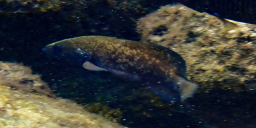
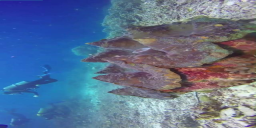
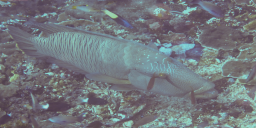
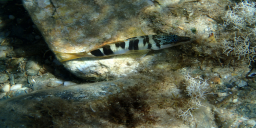
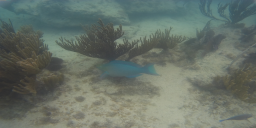
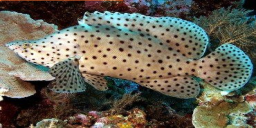
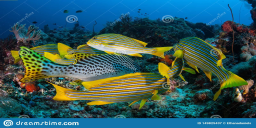
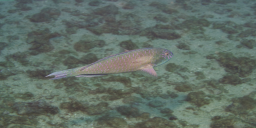
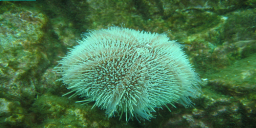
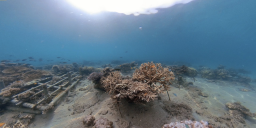
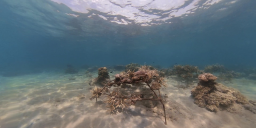
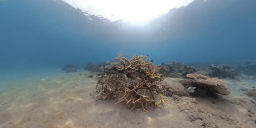
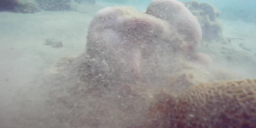
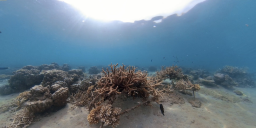
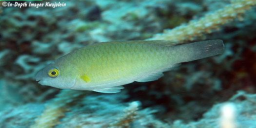
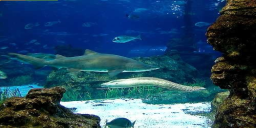

Sample image saved to: marine_detect_fishinv_sample_image.png


In [16]:
# Annotators
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_images = []

# Fixed size for each image in the grid
IMAGE_SIZE = (256, 128)  # Uniform image size
GRID_SIZE = (4, 4)  # Grid layout
DISPLAY_SIZE = (20, 12)  # Overall figure size

example_image = None

for _ in range(GRID_SIZE[0] * GRID_SIZE[1]):
    i = random.randint(0, len(dataset) - 1)
    _, image, annotations = dataset[i]
    labels = [dataset.classes[class_id] for class_id in annotations.class_id]

    # Annotate image
    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(annotated_image, annotations)
    annotated_image = label_annotator.annotate(annotated_image, annotations, labels)

    # Ensure we store one sample image for saving later
    if example_image is None and len(annotations) > 0:
        example_image = annotated_image

    # Resize image for consistent display
    if isinstance(annotated_image, np.ndarray):
        annotated_image = cv2.resize(annotated_image, IMAGE_SIZE, interpolation=cv2.INTER_AREA)
    else:
        annotated_image = Image.fromarray(annotated_image).resize(IMAGE_SIZE)

    annotated_images.append(annotated_image)

# Function to encode an image as a Base64 string
def encode_image(image):
    buf = io.BytesIO()

    # Convert PIL Image to NumPy array
    if isinstance(image, Image.Image):
        image = np.array(image)

    # Convert from BGR to RGB if needed
    if len(image.shape) == 3 and image.shape[-1] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Ensure correct data type
    if image.dtype != np.uint8:
        image = (image * 255).astype(np.uint8)  # Normalize if float

    plt.imsave(buf, image, format="png")
    buf.seek(0)
    return base64.b64encode(buf.read()).decode("utf-8")

# Encode all images
encoded_images = [encode_image(img) for img in annotated_images]

# Create an HTML grid to display images
html = f"<div style='display: grid; grid-template-columns: repeat({GRID_SIZE[1]}, 1fr); gap: 5px;'>"
for encoded_img in encoded_images:
    html += f"<img src='data:image/png;base64,{encoded_img}' width='{IMAGE_SIZE[0]}' height='{IMAGE_SIZE[1]}'/>"
html += "</div>"

# Display images in notebook
display(HTML(html))

# Save one sample image
if example_image is not None:
    example_image_path = f"{dataset_shortname}_sample_image.png"
    plt.imsave(example_image_path, example_image)
    print(f"Sample image saved to: {example_image_path}")

## Save Output
- Save example image
- Save notebook to visualize the image

PS: When running the notebook via Colab, you need to download the sample image manually and then place it in the `data_preview` folder in the `fish-datasets` repository.